The following cell contains common imports and definitions. Run it first.

In [1]:
import matplotlib.pyplot as plt
import tikzplotlib
import pickle
import json
import itertools
import numpy as np

ALGORITHMS = {
    'random': 'Random',
    'tribler': 'Tribler',
    'dinx_s': 'DINX-s',
    'dinx': 'DINX',
    'panache': 'Panaché',
    'maay': 'MAAY',
    'grank': 'G-Rank',
    'ltr': 'DART'
}


from matplotlib.lines import Line2D
from matplotlib.legend import Legend
Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols, lambda self, value: setattr(self, "_ncols", value))

def tikzplotlib_fix_ncols(obj):
    """Workaround function to fix legend column issue before saving with tikzplotlib."""
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    if hasattr(obj, 'gcf'):
        fig = obj.gcf()
        for ax in fig.get_axes():
            if hasattr(ax, 'legend_') and ax.legend_ is not None:
                if hasattr(ax.legend_, "_ncols"):
                    ax.legend_._ncol = ax.legend_._ncols
    else:
        for child in obj.get_children():
            tikzplotlib_fix_ncols(child)
    

    # from matplotlib.lines import Line2D
    # from matplotlib.legend import Legend
    # Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
    # Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
    # Legend._ncol = property(lambda self: self._ncols)

    

# Dataset Analysis

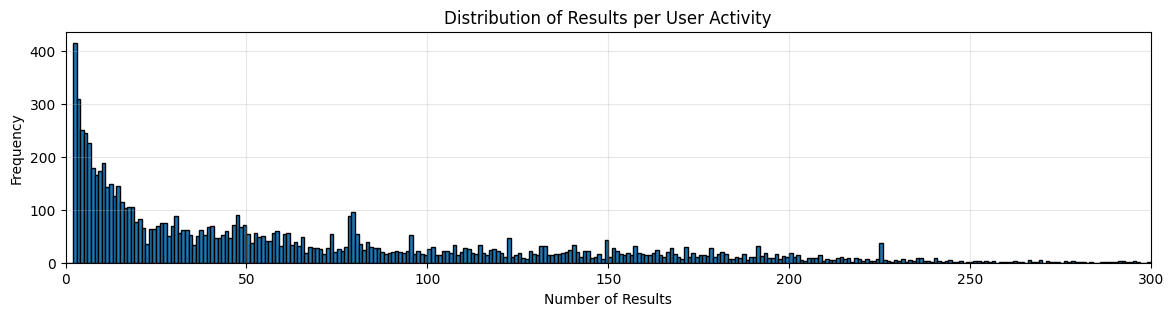

Number of activities with only one result: 975
Percentage of activities with only one result: 10.75%
Mean number of results per activity: 64.17
Median number of results per activity: 41.00


In [10]:
# Plot distribution of results per user activity
plt.figure(figsize=(14, 3))

with open('user_activities.pkl', 'rb') as f:
    user_activities = pickle.load(f)

result_counts = [len(ua.results) for ua in user_activities]

xmax = 300
plt.hist(result_counts, bins=range(xmax+1), edgecolor='black')
plt.xlabel('Number of Results')
plt.ylabel('Frequency') 
plt.title('Distribution of Results per User Activity')
plt.grid(True, alpha=0.3)
plt.xlim(0, xmax)
plt.show()

# Count activities with only one result
single_result_count = sum(1 for ua in user_activities if len(ua.results) < 5)
print(f"Number of activities with only one result: {single_result_count}")
print(f"Percentage of activities with only one result: {single_result_count/len(user_activities)*100:.2f}%")
# Calculate and print mean and median of result counts
mean_results = np.mean(result_counts)
median_results = np.median(result_counts)
print(f"Mean number of results per activity: {mean_results:.2f}")
print(f"Median number of results per activity: {median_results:.2f}")

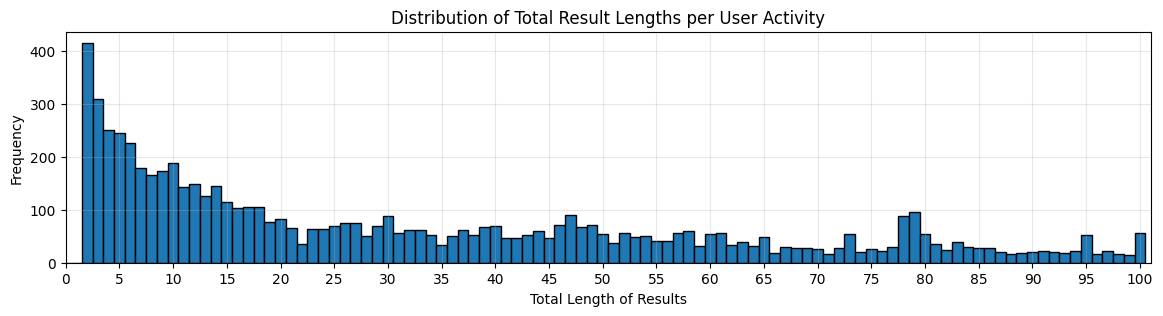

In [197]:
# Compute lengths of results per activity
result_lengths = [len(ua.results) for ua in user_activities]
xlim = 100

# Plot histogram
plt.figure(figsize=(14, 3))
plt.hist(result_lengths, bins=range(xlim + 2), edgecolor='black', align='left')
plt.xlim(0, xlim + 1)
plt.xlabel('Total Length of Results')
plt.ylabel('Frequency')
plt.title('Distribution of Total Result Lengths per User Activity')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, xlim + 1, max(1, xlim // 20)))

plt.show()

In [11]:
num_users = len(set(ua.issuer for ua in user_activities))
num_queries = len(list(ua.query for ua in user_activities))
print(f"Number of users: {num_users}")
print(f"Number of queries: {num_queries}")

Number of users: 948
Number of queries: 9068


# Chosen Ranking Positions

907
907


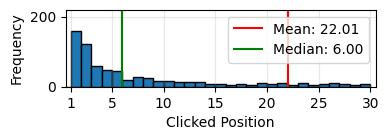

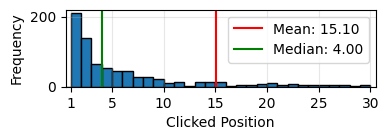

In [42]:
def plot_chosen_indices(ranking_algo):
    with open(f'results/reranked_activities/{ranking_algo}.pkl', 'rb') as f:
        user_activities = pickle.load(f)
        print(len(user_activities))
        
    chosen_indices = []
    for ua in user_activities:
        if ua.chosen_result is None:
            continue
        try:
            chosen_idx = next(i for i, r in enumerate(ua.results) if r.infohash == ua.chosen_result.infohash) + 1
            chosen_indices.append(chosen_idx)
        except StopIteration:
            # Skip if the chosen result isn't found in results list
            continue

    avg_chosen_index = np.mean(chosen_indices)
    median_chosen_index = np.median(chosen_indices)

    plt.figure(figsize=(4, 1))
    xlimit = 30
    plt.hist([x for x in chosen_indices if x <= xlimit], bins=range(xlimit+1), edgecolor='black')
    plt.axvline(avg_chosen_index, color='red', linestyle='-', label=f'Mean: {avg_chosen_index:.2f}')
    plt.axvline(median_chosen_index, color='green', linestyle='-', label=f'Median: {median_chosen_index:.2f}')
    plt.xlabel('Clicked Position')
    plt.ylabel('Frequency')
    plt.ylim(0, 220)
    plt.xlim(0.5, xlimit+0.5)
    plt.xticks([1] + list(range(5, xlimit+1, 5)))
    plt.legend()
    plt.grid(True, alpha=0.3)
    tikzplotlib_fix_ncols(plt)
    tikzplotlib.save(
        f"results/tex/chosen_indices_{ranking_algo.lower()}.tex",
        axis_width=r'\columnwidth',
        axis_height=r'3.5cm')
    
plot_chosen_indices('tribler')
plot_chosen_indices('ltr')

# Ranking Performance

In [ ]:
from common import calc_mrr, mean_recall

k_values = [1, 5, 10, 20]
header = ["Algorithm", "MRR"] + [f"Recall@{k}" for k in k_values]
print("\t".join(header))

for algo in ALGORITHMS.keys():
    with open(f'results/reranked_activities/{algo}.pkl', 'rb') as f:
        reranked_activities = pickle.load(f)

    mrrs = [calc_mrr(ua) for ua in reranked_activities]
    mrr_mean = np.mean(mrrs)
    mrr_std = np.std(mrrs)
    
    recall_scores = [mean_recall(reranked_activities, k) for k in k_values]
    
    recall_str = "\t".join([f"{recall:.2f}" for k, recall in zip(k_values, recall_scores)])
    print(f"{algo}\tMRR: {mrr_mean:.2f} ± {mrr_std:.2f}\t{recall_str}")
    

Algorithm	MRR	Recall@1	Recall@5	Recall@10	Recall@20
random	MRR: 0.18 ± 0.26	0.15	0.31	0.42	0.56
tribler	MRR: 0.32 ± 0.35	0.31	0.50	0.61	0.71
dinx_s	MRR: 0.31 ± 0.36	0.28	0.49	0.61	0.72
dinx	MRR: 0.28 ± 0.34	0.26	0.46	0.55	0.65
panache	MRR: 0.28 ± 0.35	0.25	0.43	0.53	0.64
maay	MRR: 0.27 ± 0.34	0.26	0.43	0.52	0.63
grank	MRR: 0.25 ± 0.32	0.22	0.41	0.52	0.64
ltr	MRR: 0.39 ± 0.37	0.39	0.61	0.72	0.81


# Performance with Context Size

In [91]:
all_results = {'ltr': {}}
for i in range(2,76):
    with open(f'results/context_maps/context_map_ltr_{i}_of_78.pkl', 'rb') as f:
        result = pickle.load(f)
        all_results['ltr'].update(result['ltr'])

with open('results/context_maps.pkl', 'rb') as f:
    all_results.update(pickle.load(f))

filtered_results = {}
for algo_name, index_dict in all_results.items():
    filtered_results[algo_name] = {x: metrics[None] for x, metrics in index_dict.items()}

all_ndcgs = filtered_results

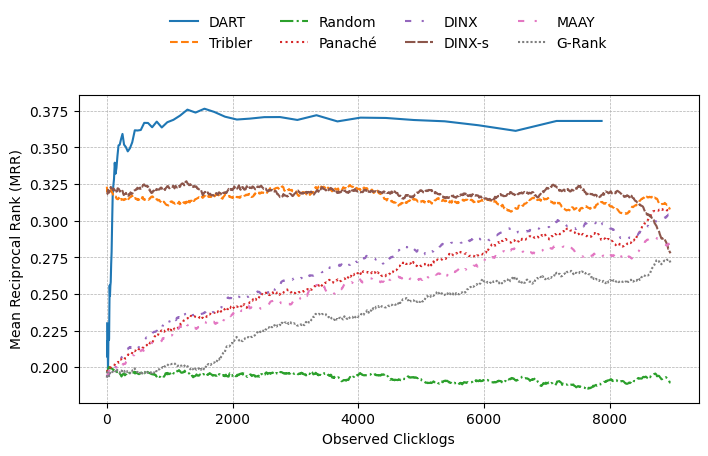

In [93]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

def simple_moving_average(data, window_size):
    """Apply simple moving average with a fixed window size, ensuring length consistency."""
    if len(data) < window_size:
        return np.array(data)  # Return original if not enough data points
    smoothed = np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    # Pad to maintain original length
    pad_size = (len(data) - len(smoothed)) // 2
    smoothed = np.pad(smoothed, (pad_size, len(data) - len(smoothed) - pad_size), mode='edge')

    return smoothed

def log_adaptive_moving_average(data, x, min_window, max_window):
    """Apply adaptive smoothing where the window size decreases logarithmically with x."""
    smoothed_data = []
    x_min = x[0] if x[0] != 0 else 1e-10  # Avoid division by zero

    for i in range(len(data)):
        log_x = np.log1p(x[i] - x_min)
        max_log_x = np.log1p(x[-1] - x_min)

        # Flip the scaling
        window_size = int(max_window - (max_window - min_window) * (log_x / max_log_x))
        window_size = max(1, window_size)  # Ensure at least a window size of 1

        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(data), i + window_size // 2)
        smoothed_data.append(np.mean(data[start_idx:end_idx]))

    return np.array(smoothed_data)

def downsample_data(x, y, num_points=1000):
    """Downsample (x, y) to at most num_points points while preserving trends."""
    if len(x) <= num_points:
        return x, y  # No need to downsample

    indices = np.round(np.linspace(0, len(x) - 1, num_points)).astype(int)
    return [x[i] for i in indices], [y[i] for i in indices]

cmap = plt.get_cmap("tab10")
colors = list(cmap.colors[:8])  # Extract the first eight colors

line_styles = [
    '-',                # solid
    '--',               # dashed
    '-.',               # dash-dot
    ':',                # dotted
    (0, (3, 5, 1, 5, 1, 5)),       # custom dash pattern: dash dot dotted
    (0, (5, 1)),        # custom dash pattern: long dashes with short gaps
    (0, (3, 5, 1, 5)),   # custom pattern: alternating short and long dashes
    (0, (1, 1))         # custom dash pattern: densely dotted/dashed
]

color_cycle = itertools.cycle(colors)
style_cycle = itertools.cycle(line_styles)

fig, ax1 = plt.subplots(figsize=(8, 4))

for algo_name, index_dict in all_ndcgs.items():
    x_filtered = sorted(index_dict.keys())
    y_vals = [index_dict[x] for x in x_filtered]

    if "ltr" in algo_name.lower():
        smoothed_vals = log_adaptive_moving_average(y_vals, x_filtered, 20, 2)
    else:
        smoothed_vals = log_adaptive_moving_average(y_vals, x_filtered, 300, 100)

    x_downsampled, y_downsampled = downsample_data(x_filtered, smoothed_vals, num_points=1000)
    
    color = next(color_cycle)
    style = next(style_cycle)
    
    ax1.plot(
        x_downsampled,
        y_downsampled,
        label=ALGORITHMS[algo_name],
        linestyle=style,
        color=color
    )

ax1.set_xlabel('Observed Clicklogs')
ax1.set_ylabel('Mean Reciprocal Rank (MRR)')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=4, frameon=False)


tikzplotlib_fix_ncols(plt)

tikzplotlib.save("results/tex/context_plot.tex", axis_width=r'\columnwidth', axis_height=r'5cm')


# Decentralized Setting

Number of users:  112


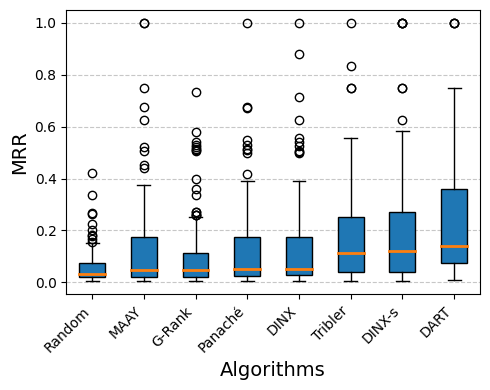

In [13]:
from statistics import median

with open("results/p2p.json", "r") as f:
    data = json.load(f)

print("Number of users: ", len(data['tribler']))

ndcg_data = {}
for algorithm, algorithm_name in ALGORITHMS.items():
    if algorithm not in data:
        print(f"Warning: '{algorithm}' not found in the data. Skipping.")
        continue  # Skip to the next algorithm if not found
    items = data[algorithm]
    values = [item['map'].get("null") for item in items if 'map' in item and item['map'].get("null") is not None]
    ndcg_data[algorithm] = values

# Order algorithms by median NDCG in ascending order
ordered_algorithms = sorted(ndcg_data.keys(), key=lambda algo: median(ndcg_data[algo]) if ndcg_data[algo] else float('inf'))
data_to_plot = [ndcg_data.get(algo, []) for algo in ordered_algorithms]

plt.figure(figsize=(5, 4))
plt.boxplot(data_to_plot, patch_artist=True, medianprops={'linewidth': 2})

plt.xticks([i + 1 for i in range(len(ordered_algorithms))], [ALGORITHMS[algo] for algo in ordered_algorithms], rotation=45, ha='right')
plt.ylabel(f'MRR', fontsize=14)
plt.xlabel('Algorithms', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
tikzplotlib_fix_ncols(plt)
tikzplotlib.save("results/tex/p2p_map.tex", axis_width=r'\columnwidth', axis_height=r'6cm')


## T-Test for Significant Differences

In [18]:
from scipy.stats import ttest_ind
import pandas as pd

# Perform t-tests between all pairs of algorithms
t_test_results = []

for i, algo1 in enumerate(ordered_algorithms):
    for j, algo2 in enumerate(ordered_algorithms):
        if i < j:  # Only compare pairs once
            values1 = ndcg_data[algo1]
            values2 = ndcg_data[algo2]

            # Ensure there are values to compare
            if values1 and values2:
                t_stat, p_value = ttest_ind(values1, values2, equal_var=False)  # Welch's t-test
                t_test_results.append({
                    'Algorithm 1': ALGORITHMS[algo1],
                    'Algorithm 2': ALGORITHMS[algo2],
                    'T-statistic': round(t_stat, 3),
                    'P-value': round(p_value, 5),
                    'Significant': 'Yes' if p_value < 0.05 else 'No'
                })

# Create a table for the results
t_test_results_df = pd.DataFrame(t_test_results)
t_test_results_df = t_test_results_df.sort_values(by='P-value', ascending=True)

# Print the table as TSV
tsv_output = t_test_results_df.to_csv(sep='\t', index=False)
tsv_output


	Random	MAAY	G-Rank	Panaché	DINX	Tribler	DINX-s	DART
Random	-	0.00017120029212789003	0.0018492179008417788	0.00012083990385671724	7.05409469038049e-05	6.222416119111933e-09	6.209055532878112e-09	1.7514718031947402e-12
MAAY	0.00017120029212789003	-	0.2738134587298486	0.8565178353834519	0.9204252588382567	0.05399255744304546	0.018023095059061238	0.0006717983376623706
G-Rank	0.0018492179008417788	0.2738134587298486	-	0.3391134096493291	0.22048683059176347	0.00155412650414305	0.0004543023104275134	3.2514376062620997e-06
Panaché	0.00012083990385671724	0.8565178353834519	0.3391134096493291	-	0.7730732506104704	0.02898018876264144	0.009052777004591754	0.00022298827374607106
DINX	7.05409469038049e-05	0.9204252588382567	0.22048683059176347	0.7730732506104704	-	0.06334680795044906	0.021232306245865237	0.0008020129895704582
Tribler	6.222416119111933e-09	0.05399255744304546	0.00155412650414305	0.02898018876264144	0.06334680795044906	-	0.5669993958511508	0.12039992495400068
DINX-s	6.209055532878112